Lo primero es el webscrapping

Cargas el siguiente cuadro y en el navegador que se abre vas a la página que deseas leer y luego presionas "Guardar html", le pones el nombre que corresponda según el cuadro de código que lo leerá y ya está, tienes que asegurarte de hacer eso con todas las cuentas

In [1]:
#intento de scrapping de cuentas con metodo nuevo (estoy intentando inventar un método para mejorar el scrapping)#

# Importamos las librerias necesarias
from sys import argv
from PyQt5.QtWebEngineWidgets import QWebEngineView
from PyQt5.QtWidgets import QWidget, QApplication, QLineEdit, QVBoxLayout, QHBoxLayout, QPushButton, QProgressBar,QFileDialog
from PyQt5.QtCore import QUrl, QEventLoop, pyqtSignal, pyqtSlot

class PyChrome(QWidget):
    htmlFinished = pyqtSignal()
    def __init__(self):
        super().__init__()

        # Comenzamos definiendo algunas caracteristicas de la ventana
        self.resize(740, 520)  # Tamaño de la ventana
        self.setWindowTitle('Datasea')  # Titulo de la ventana... como es para extraer datos por ahora se me ocurrió un nombre como "datasea"

        # Creamos la barra de busqueda
        # la variable page sera el texto por defecto
        page = "https://www.paypal.com/myaccount/activities/?free_text_search=&start_date=2022-01-01&end_date=2022-06-22&type=&status=&currency=&filter_id=&issuance_product_name=&asset_names=&asset_symbols="
        self.url = QLineEdit(page)
        self.url.setPlaceholderText(page)

        # Creamos el boton 'atras'
        self.back = QPushButton("Atras")
        self.back.clicked.connect(self.pagina_anterior)

        # Creamos el boton que iniciara la busqueda
        self.go = QPushButton("Ir")
        self.go.clicked.connect(self.btnIrClicked)

        # Boton de marcadores
        self.save_marker = QPushButton("Guardar")
        self.save_marker.clicked.connect(self.guardar_marcador)

        #boton para obtener html
        self.mHtml = ""
        self.save_html = QPushButton("Guardar html") #"guardar html"
        self.save_html.clicked.connect(self.save_file)
        
        #boton: ir a la cuenta del banreservas
        self.mHtml = ""
        self.go_banreservas = QPushButton("Ir Banreservas") #"guardar html"
        self.go_banreservas.clicked.connect(self.btnIrReservas)
        
        # Generamos un QHBoxLayout y agregamos los widget creados anteriormente
        self.nav_bar = QHBoxLayout()
        self.nav_bar.addWidget(self.back)
        self.nav_bar.addWidget(self.url)
        self.nav_bar.addWidget(self.go)
        self.nav_bar.addWidget(self.save_marker)
        self.nav_bar.addWidget(self.save_html)
        self.nav_bar.addWidget(self.go_banreservas)
        
        # Barra de progreso
        self.progress = QProgressBar()
        self.progress.setValue(0)

        # # Cuerpo HTML que mostraremos al iniciar la pagina
        html = """
        <!DOCTYPE HTML>
            <html>
                <head>
                    <title>AdventistaADE</title>
                </head>
                <body>
                <style>
                    *{
                    font-family: Arial;
                    }
                </style>
                    <h1>Oceano de datos (Datasea)</h1>
                    <img src=""/>
                    <p>Bienvenido al oceano de datos, tu herramienta para hacer webscrapping; tu propio navegador Saulecast
                </body>
            </html>
        """

        # Asignamos el cuerpo HTML por defecto que hemos escrito
        self.web_view = QWebEngineView()
        self.web_view.loadProgress.connect(self.webLoading)
        self.web_view.setHtml(html)

        # Creamos un QVBoxLayout y agregamos la barra de navegación, el cuadro de la pagina y la barra de progreso
        root = QVBoxLayout()
        root.addLayout(self.nav_bar)
        root.addWidget(self.web_view)
        root.addWidget(self.progress)
        self.setLayout(root)
        
        self.web_view.loadFinished.connect(self.on_loadFinished)


    def callback(self, html):
        self.mHtml = html
        self.htmlFinished.emit()

    def save_file(self):
        filename, _ = QFileDialog.getSaveFileName(self, "Save Page As", "", "Hypertext Markup Language (*.htm *.html);;" "All files(*.*)")
        if filename:
            self.web_view.page().toHtml(self.callback)
            loop = QEventLoop()
            self.htmlFinished.connect(loop.quit)
            loop.exec_()
            with open(filename, 'w', encoding="utf-8") as f:
                f.write(self.mHtml)
    
    def btnIrReservas(self,event):
        url = QUrl("https://www.banreservas.com.do/TuBancoPersonas/Default.aspx")
        self.web_view.page().load(url)
    
    # Creamos una función que sera la que hara la busqueda de la pagina
    def btnIrClicked(self, event):
        url = QUrl(self.url.text())
        self.web_view.page().load(url)

    # Actualizamos el valor de la barra de progreso
    def webLoading(self, event):
        self.progress.setValue(event)

    def pagina_anterior(self): #hay que diseñar esta función
        pass 
    def guardar_marcador(self): #hay que diseñar esta función
        print(self.url.text())
        
    
    @pyqtSlot(bool)
    def on_loadFinished(self, ok):
        if not ok:
            return
        xpath = r'//*[@id="forgotPassword"]'
        s = (
            """
            (function() {
                var banner = document.evaluate("%s", document, null, XPathResult.FIRST_ORDERED_NODE_TYPE, null).singleNodeValue;
                banner.click()
            })()"""
            % xpath
        )
        self.web_view.page().runJavaScript(s)



if __name__ == '__main__':
    # Creamos la instancia de la clase creada y mostramos la ventana en pantalla
    app = QApplication(argv)
    win = PyChrome()
    win.show()
    win.btnIrClicked("evento")
    app.exec_()
    del app


: 

In [4]:
# Importaciones
from bs4 import BeautifulSoup
import pandas as pd


Empezamos las lecturas de los html, cada cuadro lee una cuenta diferente y empezamos por paypal. Al leer los html con bs4 luego se guarda la información seleccionada, organizada y clasificada en un .csv

Algunas cuentas como las del banreservas es mejor solo exportar el csv que te ofrece la página (paypal también ofrece pero me pareció insuficiente así que mejor extraje de un html).

In [26]:
#Leamos, procesemos y despleguemos la informacion de paypal

with open("paypal_trans.html", encoding="utf-8") as ppt:
    ppt_data = ppt.read()
    soup = BeautifulSoup(ppt_data, "html.parser")
    # print(soup.prettify())
    
   #this contains all transactions data of the page
    container = soup.find("div", attrs={"data-testid":"activity-tile"}) #container = soup.find(id="app") takes too much childs
    # print(container.prettify())
     
    #names of the other persons in the transactions. I take the id from the class name of the container of all the transactions, just taking this will be easier than looping from this general container but i will still be able to identify the transaction just in case. Yes, this is the real paypal transation id
    #taking the name and the id together isntead of individual will make this more secure since we can now for sure that the id corresponds to this specific transaction
    counterparties = {}
    cnames = [] #the pandas dataframes does not accepts
    for name in container.findAll('div',
                                 attrs={"data-cy":'counterpartyName'}):
        transaction_id = name.parent.parent.parent.parent["class"][1][19:]
        counterparties[name.text] = transaction_id
        cnames.append(name.text)
    print(counterparties)
    print(cnames)
    
    #dates and info are together, i'll extract and separe them. This way is easier
    dates = []
    info = [] #type of transaction
    for date in container.findAll('div',
                                  attrs={"transaction-date-type-status-container"}):
        date_info = date.text
        dot = str.find(date_info,".")
        dates.append(date_info[:dot+1])
        info.append(date_info[dot+1:])
    print(dates)
    print(info)
    
    #amount of the transactions
    amounts = []
    change = [] #is the amount plus the symbol of subtraction or adittion as corresponds
    for amount in container.findAll('div',
                                 attrs={"data-cy":'transactionAmount'}):
        amounts_change = amount.text
        change.append(amounts_change)
        if amounts_change[len(amounts_change)-1].isdigit() == True: #this is to delete the name of the currency from the end of the number (just in non USD trnasactions)
            amounts.append(amounts_change[2:])
        else:
            amounts.append(amounts_change[2:len(amounts_change)-4])
    print(amounts)
    print(change)
    
    #messages left with the transaction
    messages = {}
    for message in container.findAll('div',
                                 attrs={"data-cy":'notes'}):
        # transaction_id = message.parent.parent.parent.parent["class"][1][19:]
        date_of_message = message.parent.parent.parent.parent.find(
            'div', attrs={"transaction-date-type-status-container"}) #I take the date because is a lot easier to find the index using this (not every transaction have a message)
        messages[date_of_message.text[:str.find(date_of_message.text, ".")+1]] = message.text
    print(messages)
        
    #every transaction have a link to acces to a very more detailed info about them, here is get this link. In the link i can find things like paypal comision, counterparty contact info, counterparty direction and transaction id
    details_links = []
    for counterpart in container.findAll('div',
                                 attrs={"data-cy":'counterpartyName'}): #i take part of the classes name to find them
        details = counterpart.parent.parent.parent.parent
        details_links.append("https://www.paypal.com"+details["data-href"])
    print(details_links)
    
    #Use pandas to create the .csv
    messages2 = [] #lets make the messages dictionary bigger,a list and with the correct index to make it adecuate for the data frame
    for date in dates:
        if date not in messages:
            messages2.append("")
        else:
            messages2.append(messages[date])
    info = {"Nombre": cnames, "Fecha": dates, "Tipo":info, "Cantidad":amounts, "Efecto":change, "Mensaje": messages2,"Detalles":details_links}
    df = pd.DataFrame(data = info)
    print(df)
    df.to_csv('paypal_data.csv')#, index=False, sep="\t")


{'FIVERR INTERNATIONAL LTD.': '4FC79989B1581434U', 'Lawal Ganiy': '0YH67521MN069303R', 'Mohamed Sellaki': '7U648492D3765863K', 'Red Pick Media': '4J188408UB7917540', 'Ajayi Ruth': '0SK943351R374253M'}
['FIVERR INTERNATIONAL LTD.', 'FIVERR INTERNATIONAL LTD.', 'Lawal Ganiy', 'Mohamed Sellaki', 'Red Pick Media', 'FIVERR INTERNATIONAL LTD.', 'Red Pick Media', 'Ajayi Ruth']
['12 jun.', '8 may.', '19 abr.', '13 abr.', '9 abr.', '8 abr.', '6 abr.', '18 mar.']
['Pago recibido', 'Pago recibido', 'Dinero recibido', 'Dinero recibido', 'Dinero enviado', 'Pago recibido', 'Dinero recibido', 'Dinero recibido']
['$270.39', '$32.00', '$25.24', '$70.00', '€21.9', '$76.00', '$47.21', '$47.00']
['+ $270.39', '+ $32.00', '+ $25.24', '+ $70.00', '- €21.92EUR', '+ $76.00', '+ $47.21', '+ $47.00']
{'18 mar.': '"Freelance"'}
['https://www.paypal.com/myaccount/transactions/details/9U161792E4998173W', 'https://www.paypal.com/myaccount/transactions/details/4EF439847G193344H', 'https://www.paypal.com/myaccount/tr

In [40]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Debajo están las evaluaciones de la cuenta de paypal

In [41]:
#leer csv, pandas
df = pd.read_csv("paypal_data.csv")
# print(df.head())
print(df.columns.tolist())


['Unnamed: 0', 'Nombre', 'Fecha', 'Tipo', 'Cantidad', 'Efecto', 'Mensaje', 'Detalles']


['270.39$', '32.00$', '25.24$', '70.00$', '21.9$', '76.00$', '47.21$', '47.00$']
[6.12, 5.8, 4.19, 4.13, 4.9, 4.8, 4.6, 3.18]


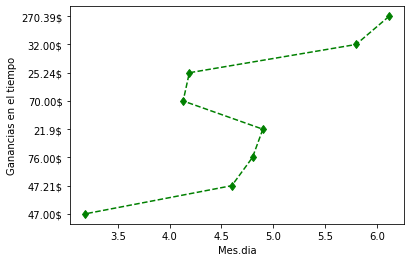

([<matplotlib.axis.XTick at 0x1d5d47922e0>,
 [Text(0.0, 0, '6.12'),
  Text(1.0, 0, '5.8'),
  Text(2.0, 0, '4.19'),
  Text(3.0, 0, '4.13'),
  Text(4.0, 0, '4.9'),
  Text(5.0, 0, '4.8'),
  Text(6.0, 0, '4.6'),
  Text(7.0, 0, '3.18')])

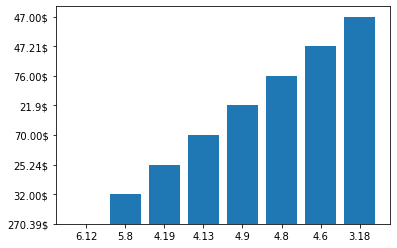

In [151]:
#Matplotlib
amount = []
for earn in df["Cantidad"]:
    amount.append(earn[1:]+"$")
print(amount)
dates = []
for date in df["Fecha"]:
    month = {
        'ene.': "1",
        'feb.': "2",
        'mar.': "3",
        'abr.': "4",
        'may.': "5",
        'jun.': "6",
        'jul.': "7",
        'ago.': "8",
        'sep.': "9",
        'oct.': "10",
        'nov.': "11",
        'dic.': "12"
        }
    dates.append(float("{0}.{1}".format(month[date[str.find(date," ")+1:]],date[:2])))
print(dates)
plot1 = plt.subplot()
plot1.plot(dates, amount, 'g--d') #g--d == green diamond; sorted(amount) organizaría la lista
# plot1.invert_xaxis()
plot1.invert_yaxis()
plt.ylabel('Ganancias en el tiempo')
plt.xlabel('Mes.dia')
plt.show()

# plt.bar(amount, height=amount)
# plt.xticks(amount, dates)


Debajo están las evaluaciones de la cuenta de Banreservas

In [ ]:
#leer csv, pandas


In [ ]:
#Matplotlib


Primero hay un bloque que le da formato a todos los csv en una copia para que todos los datos puedan ser leidos juntos. Luego:

Debajo están las evaluaciones de la cuenta en conjunto. Todos mis datos financieros. 

In [ ]:
#dar formato a todos los csv de las cuentas. adaptar las dimesiones en largo, número y nombre de columnas

In [ ]:
#Matplotlib
